For Week 3's homework, please calibrate your own camera. You can use OpenCV, and the checkerboard image that I provided, but you are free to explore other more challenging options. 

Please upload images with corners detected in a .zip file, and a .txt file containing your calibration results (only the calibration matrix and distortion coefficient would be enough). If you are not sure what "images with corners detected" means, check out the examples in the notebook!

Please make sure that the checkerboard image has black and white squares, not just any rectangles, as this assumption is baked into the algorithm we demonstrated in class.

I would avoid using expensive smartphones for better results. Usually, a webcam provides better results, but you can definitely try and see with your phone camera

In [12]:
# import relevant package
import numpy as np
import cv2
import matplotlib.pyplot as plt
# this package is to read several files in a folder
import glob

# Camera Calibration

This section will introduce you to OpenCV's camera calibration process. This method, usually called Zhang's method, is published by Zhengyou Zhang from Microsoft Research in a paper titled "A flexible new technique for camera calibration". [Link to the original paper here](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr98-71.pdf).

We will be using a chessboard image to do camera calibration.

The notebook is adapted from OpenCV's [Tutorial on Camera Calibration](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html).

### Ideal model

First step, we need an "ideal model" of point locations on a chessboard. We will use a 7*6 chessboard, so the layout of points follow that. 

I will not dive into the details of these numpy code that generate such (x, y, z) coordinates. You are welcome to reach out to me during office hour to let me walk you through these Python tricks if interested. But generally they are not terribly important and there are many alternative ways to achieve the same thing.

It's worth noting that all the points are in 3-dimensional space, but since they should all reside on a checkerboard, the z coordinates are all 0.

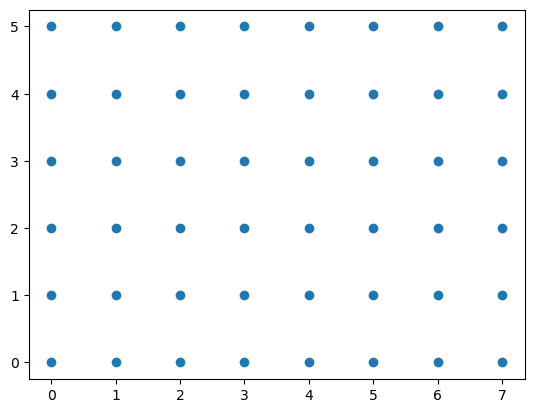

In [13]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*8,3), np.float32)
objp[:,:2] = np.mgrid[0:8,0:6].T.reshape(-1,2)


plt.scatter(objp[:, 0], objp[:, 1]);

# Camera calibration with your own camera!

It may takes some time to boot up OpenCV's video capture functionality, so be patient. 

After a windows pop up, hit Space to take a photo and hit Esc to exit.

In [14]:
# Capture chessboard images from camera

import cv2

cam = cv2.VideoCapture(0)

cv2.namedWindow("test")

img_counter = 0

while True:
    ret, frame = cam.read()
    if not ret:
        print("failed to grab frame")
        break
    cv2.imshow("test", frame)

    k = cv2.waitKey(1)
    if k%256 == 27:
        # ESC pressed
        print("Escape hit, closing...")
        break
    elif k%256 == 32:
        # SPACE pressed
        img_name = "opencv_frame_{}.jpg".format(img_counter)
        cv2.imwrite(img_name, frame)
        print("{} written!".format(img_name))
        img_counter += 1

cam.release()

cv2.destroyAllWindows()

Escape hit, closing...


We now use the `glob` package to collect all the photos we took of this chessboard for calibration. 

Here, * indicates a wildcard character. Basically it means that glob will grab any file that starts with "left", followed by some characters, and ends with ".jpg".

In [15]:
images = glob.glob('opencv_frame_*.jpg')
# images = glob.glob('chess*.jpg')
# images = glob.glob('left*.jpg')
print(images)


['opencv_frame_0.jpg', 'opencv_frame_1.jpg', 'opencv_frame_10.jpg', 'opencv_frame_11.jpg', 'opencv_frame_12.jpg', 'opencv_frame_13.jpg', 'opencv_frame_14.jpg', 'opencv_frame_2.jpg', 'opencv_frame_3.jpg', 'opencv_frame_4.jpg', 'opencv_frame_5.jpg', 'opencv_frame_6.jpg', 'opencv_frame_7.jpg', 'opencv_frame_8.jpg', 'opencv_frame_9.jpg']


We create some variables that will remain the same or will be modified inplace throughout the entire algorithm so we don't recreate them every time we process one photo.

In [16]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

# termination criteria for cornerSubPix. 
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)


The next code block will find corners(intersections) on the photos of checkerboard.

In [18]:
for fname in images:
    
    
    # * 1) First, use OpenCV's IO to read one image at a time based on files grabbed by glob and convert it to grey scale.
    img = cv2.imread(fname)
    
    # Resize to make sure the image does not contain too much pixels for Opencv to find patterns
    img = cv2.resize(img, (640,480))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
    # * 2) Feed the image to `cv2.findChessboardCorners`. We specify that the chessboard in use is 7*6.
    # Find the chess board corners, we use 7*6 grid
    ret, corners = cv2.findChessboardCorners(gray, (8,6),None)


    # * If `cv2.findChessboardCorners` does find corners, we use `cv2.cornerSubPix` to further improve the accuracy of such corners. 
    # * Here we make use of the `criteria` as the termination criteria.
    # If found, add object points, image points (after refining them)
    if ret == True:
        print("Here")
        objpoints.append(objp)

        # cv2.cornerSubPix() increases the accuracy of the corner coordinates
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        
        # * We append the coordinates of "ideal points" to `objpoints`, and the corner coordinates we just find to `imgpoints`, 
        # * so we have correspondency for every photo of the checkerboard.
        
        imgpoints.append(corners2)

        # Draw and display the corners

        # * Visualize the corners we found on the photo using `cv2.drawChessboardCorners`.
        img = cv2.drawChessboardCorners(img, (8,6), corners2,ret)
        # replace the colab_imshow with the commented lines if on a local Jupyter environment
        
        cv2.imshow('img',img)
        
        # img_name = "calibrated_img{}.jpg".format(img_counter)
        # cv2.imwrite(img_name, frame)
        # print("{} written!".format(img_name))
        cv2.waitKey(2000)
        
        # * Repeat this process for all the photos we've taken, which is 15 times in our case.
cv2.destroyAllWindows()

        # ! Actual checkerboard is 8*7 but 7*6 is also fine because it is smaller than the checkerboard
        

Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here
Here


Now with correspondency, we can pass all the coordinates and the shape of the image to `cv2.calibrateCamera`. The two `None` here are not relevant in our setup, but you are welcome to take a look at `cv2.calibrateCamera` documentation to figure out why they are here.

In [9]:
# cv2.calibrateCamera() returns the camera matrix, distortion coefficients, rotation vectors, and translation vectors
# print(objpoints)
# print(imgpoints)
# print(gray)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

In [11]:
# print the values
# print(mtx)
# print(dist)
# print(rvecs)
# print(tvecs)

print("Calibration matrix: ", mtx)
print("Distortion coefficients: ", dist)

Calibration matrix:  [[503.98984186   0.         319.27822574]
 [  0.         504.10650755 244.50011269]
 [  0.           0.           1.        ]]
Distortion coefficients:  [[ 6.03664664e-02 -1.63309757e-01 -1.66674171e-05  2.79719457e-04
   2.46489340e-01]]


# Undistortion

As we can see from the following picture, sometimes in a distorted photo, lines that are supposed to be straight are appearing as curves. This is when we know that we will need to undistort the image first to do any further processing, as many algorithms introduced in this class assumes a perfectly linear camera model.

We utilize `cv2.getOptimalNewCameraMatrix` to refine the camera matrix.

If we pass 1 in as parameter, the undistorted image will most likely lose some pixels at the corners of the image. If we use 0, the undsitorted image will most likely have some dark pixels as fillers at the conrner (although not very obvious in this specific example).

In [ ]:
# Refine the camera matrix 
img = cv2.imread('opencv_frame_2.jpg')
h,  w = img.shape[:2]
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

# undistort
dst = cv2.undistort(img, mtx, dist, None, newcameramtx)

# crop the image
x,y,w,h = roi
dst = dst[y:y+h, x:x+w]
plt.imshow(dst)

In [ ]:
img = cv2.imread('opencv_frame_2.jpg')
plt.imshow(img)

In [ ]:
# Find the re-projection error which measures how exact is the found parameters

mean_error = 0
for i in range(len(objpoints)):
    # transform the object point to image point
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    # calculate the absolute norm between our transformation and the corner finding algorithm
    error = cv2.norm(imgpoints[i],imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    mean_error += error

print ("total error: ", mean_error/len(objpoints) * 100, "%")